In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28)


AxesImage(54,36;334.8x217.44)


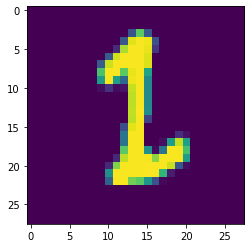

In [6]:
print(plt.imshow(x_train[70]))

In [7]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [9]:
# Dimensionality of the latent space
latent_dim = 100

In [10]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [11]:
# Get the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [12]:
# Compile both models in preparation for training

# Build and compile the "discriminator"
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained, freeze the weights of "discriminator"
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [15]:
# Train the GAN


# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [16]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [17]:
# Main training loop
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)


    #######################
    ### Train generator ###
    #######################

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
            d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
        sample_images(epoch)


epoch: 1/30000, d_loss: 0.84,             d_acc: 0.27, g_loss: 0.66
epoch: 101/30000, d_loss: 0.05,             d_acc: 1.00, g_loss: 3.83
epoch: 201/30000, d_loss: 0.40,             d_acc: 0.81, g_loss: 1.50
epoch: 301/30000, d_loss: 0.73,             d_acc: 0.41, g_loss: 0.59
epoch: 401/30000, d_loss: 0.67,             d_acc: 0.50, g_loss: 0.66
epoch: 501/30000, d_loss: 0.68,             d_acc: 0.47, g_loss: 0.67
epoch: 601/30000, d_loss: 0.68,             d_acc: 0.52, g_loss: 0.66
epoch: 701/30000, d_loss: 0.69,             d_acc: 0.52, g_loss: 0.70
epoch: 801/30000, d_loss: 0.67,             d_acc: 0.53, g_loss: 0.69
epoch: 901/30000, d_loss: 0.69,             d_acc: 0.50, g_loss: 0.77
epoch: 1001/30000, d_loss: 0.65,             d_acc: 0.66, g_loss: 0.78
epoch: 1101/30000, d_loss: 0.64,             d_acc: 0.64, g_loss: 0.78
epoch: 1201/30000, d_loss: 0.69,             d_acc: 0.47, g_loss: 0.75
epoch: 1301/30000, d_loss: 0.65,             d_acc: 0.64, g_loss: 0.80
epoch: 1401/30000,

epoch: 11601/30000, d_loss: 0.68,             d_acc: 0.53, g_loss: 0.84
epoch: 11701/30000, d_loss: 0.66,             d_acc: 0.64, g_loss: 0.81
epoch: 11801/30000, d_loss: 0.70,             d_acc: 0.55, g_loss: 0.74
epoch: 11901/30000, d_loss: 0.68,             d_acc: 0.52, g_loss: 0.86
epoch: 12001/30000, d_loss: 0.66,             d_acc: 0.56, g_loss: 0.78
epoch: 12101/30000, d_loss: 0.68,             d_acc: 0.59, g_loss: 0.79
epoch: 12201/30000, d_loss: 0.68,             d_acc: 0.66, g_loss: 0.83
epoch: 12301/30000, d_loss: 0.67,             d_acc: 0.61, g_loss: 0.81
epoch: 12401/30000, d_loss: 0.69,             d_acc: 0.58, g_loss: 0.85
epoch: 12501/30000, d_loss: 0.72,             d_acc: 0.47, g_loss: 0.77
epoch: 12601/30000, d_loss: 0.65,             d_acc: 0.67, g_loss: 0.84
epoch: 12701/30000, d_loss: 0.67,             d_acc: 0.58, g_loss: 0.82
epoch: 12801/30000, d_loss: 0.69,             d_acc: 0.50, g_loss: 0.81
epoch: 12901/30000, d_loss: 0.68,             d_acc: 0.58, g_los

epoch: 23001/30000, d_loss: 0.70,             d_acc: 0.56, g_loss: 0.83
epoch: 23101/30000, d_loss: 0.70,             d_acc: 0.56, g_loss: 0.82
epoch: 23201/30000, d_loss: 0.63,             d_acc: 0.67, g_loss: 0.82
epoch: 23301/30000, d_loss: 0.72,             d_acc: 0.45, g_loss: 0.82
epoch: 23401/30000, d_loss: 0.68,             d_acc: 0.53, g_loss: 0.80
epoch: 23501/30000, d_loss: 0.71,             d_acc: 0.53, g_loss: 0.83
epoch: 23601/30000, d_loss: 0.66,             d_acc: 0.58, g_loss: 0.79
epoch: 23701/30000, d_loss: 0.68,             d_acc: 0.59, g_loss: 0.77
epoch: 23801/30000, d_loss: 0.65,             d_acc: 0.61, g_loss: 0.77
epoch: 23901/30000, d_loss: 0.70,             d_acc: 0.48, g_loss: 0.72
epoch: 24001/30000, d_loss: 0.71,             d_acc: 0.56, g_loss: 0.78
epoch: 24101/30000, d_loss: 0.67,             d_acc: 0.56, g_loss: 0.80
epoch: 24201/30000, d_loss: 0.72,             d_acc: 0.56, g_loss: 0.75
epoch: 24301/30000, d_loss: 0.70,             d_acc: 0.59, g_los

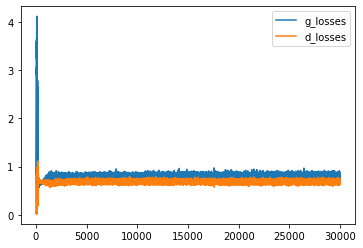

In [18]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [20]:
ls gan_images

 Volume in drive C has no label.
 Volume Serial Number is E4D8-AC1C

 Directory of C:\Users\ferna\Test\Tensorflow 2\GANs (Generative Adversarial Networks)\gan_images

02/09/2021  04:57 PM    <DIR>          .
02/09/2021  04:57 PM    <DIR>          ..
02/09/2021  03:59 PM            93,562 0.png
02/09/2021  04:01 PM            76,707 1000.png
02/09/2021  04:18 PM            47,123 10000.png
02/09/2021  04:19 PM            45,627 10200.png
02/09/2021  04:19 PM            48,010 10400.png
02/09/2021  04:20 PM            46,136 10600.png
02/09/2021  04:20 PM            44,719 10800.png
02/09/2021  04:20 PM            48,398 11000.png
02/09/2021  04:21 PM            40,156 11200.png
02/09/2021  04:21 PM            44,660 11400.png
02/09/2021  04:21 PM            49,805 11600.png
02/09/2021  04:22 PM            48,969 11800.png
02/09/2021  04:01 PM            72,820 1200.png
02/09/2021  04:22 PM            47,474 12000.png
02/09/2021  04:23 PM            43,609 12200.png
02/09/2021  04:23 PM 

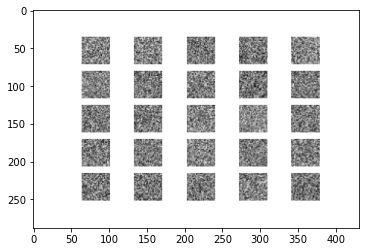

In [21]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

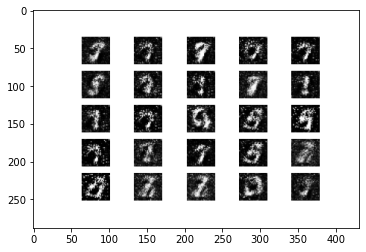

In [22]:
a = imread('gan_images/1000.png')
plt.imshow(a)

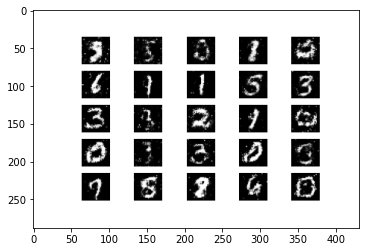

In [23]:
a = imread('gan_images/5000.png')
plt.imshow(a)

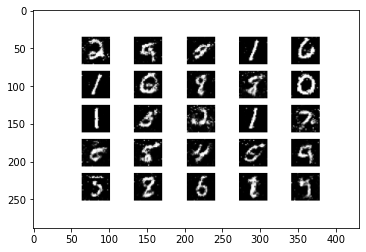

In [24]:
a = imread('gan_images/10000.png')
plt.imshow(a)

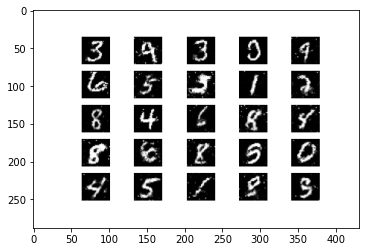

In [25]:
a = imread('gan_images/20000.png')
plt.imshow(a)

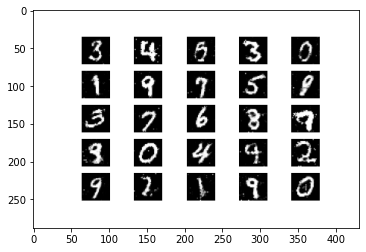

In [26]:
a = imread('gan_images/29800.png')
plt.imshow(a)